In [37]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [73]:
with open('../data/raw/static_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [74]:
df.head(1)

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_infoDefense,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_tier,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId,participant10_win
0,1402,1696419023286,13.19.534.5972,11,420,19,13,EUW1,293,MASTER,...,2,10,8,B,49.43,0.2,0.2,4544,200,True


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4438 entries, 0 to 0
Columns: 368 entries, gameDuration to participant10_win
dtypes: bool(50), float64(30), int64(176), object(112)
memory usage: 11.0+ MB


In [ ]:
import os
import sys

print(os.path.dirname(sys.executable))

In [76]:
df.describe()

,gameDuration,gameCreation,mapId,queueId,patch,seasonId,participant1_level,participant1_rank,participant1_leaguePoints,participant1_wins,...,participant10_champion_championNumber,participant10_champion_infoAttack,participant10_champion_infoDefense,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId
count,4438.000000,4.438000e+03,4438.0,4438.0,4438.000000,4438.0,4438.000000,4438.000000,4438.000000,4438.000000,...,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000
mean,1610.889590,1.696736e+12,11.0,420.0,19.327850,13.0,465.135872,1.124380,542.119423,175.020505,...,263.900406,3.780306,4.830104,5.669220,5.410320,50.584047,7.582267,7.582267,23405.229608,199.977467
std,322.028923,3.835293e+08,0.0,0.0,0.469483,0.0,317.276315,0.527654,326.426284,118.399309,...,227.747752,2.336316,2.497233,2.498429,2.188328,1.257968,8.037082,8.037082,11871.212538,1.501089
min,960.000000,1.695795e+12,11.0,420.0,19.000000,13.0,34.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,45.900000,0.100000,0.100000,1564.000000,100.000000
25%,1388.000000,1.696476e+12,11.0,420.0,19.000000,13.0,186.250000,1.000000,314.000000,86.000000,...,53.000000,2.000000,3.000000,5.000000,5.000000,49.890000,2.600000,2.600000,12378.000000,200.000000
50%,1578.500000,1.696855e+12,11.0,420.0,19.000000,13.0,441.000000,1.000000,573.000000,156.000000,...,201.000000,4.000000,5.000000,6.000000,6.000000,50.650000,5.700000,5.700000,24020.000000,200.000000
75%,1818.000000,1.697050e+12,11.0,420.0,20.000000,13.0,715.000000,1.000000,762.000000,257.000000,...,497.000000,5.000000,6.000000,8.000000,7.000000,51.150000,6.200000,6.200000,32255.000000,200.000000
max,2998.000000,1.697291e+12,11.0,420.0,20.000000,13.0,1475.000000,4.000000,1615.000000,588.000000,...,902.000000,10.000000,10.000000,10.000000,10.000000,54.120000,48.900000,48.900000,92723.000000,200.000000


In [77]:
df.dtypes

gameDuration                          int64
gameCreation                          int64
gameVersion                          object
mapId                                 int64
queueId                               int64
                                     ...   
participant10_champion_pick_rate    float64
participant10_champion_ban_rate     float64
participant10_champion_matches        int64
participant10_teamId                  int64
participant10_win                      bool
Length: 368, dtype: object

<Axes: >

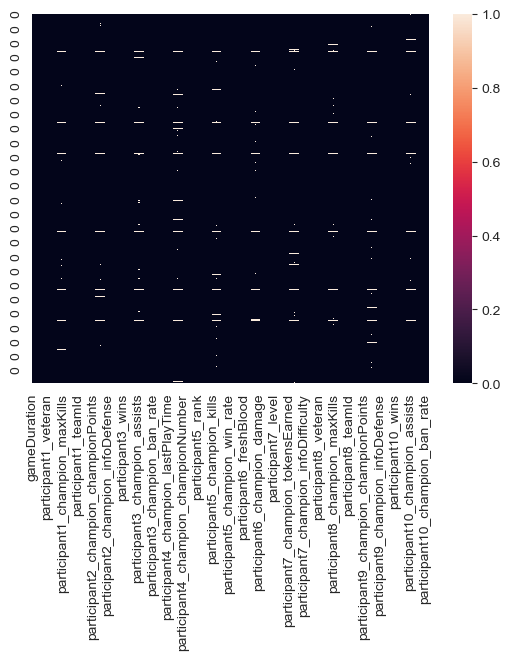

In [78]:
sns.heatmap(df.isna())

C:\Users\morit\AppData\Local\Temp\ipykernel_21920\1072140413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

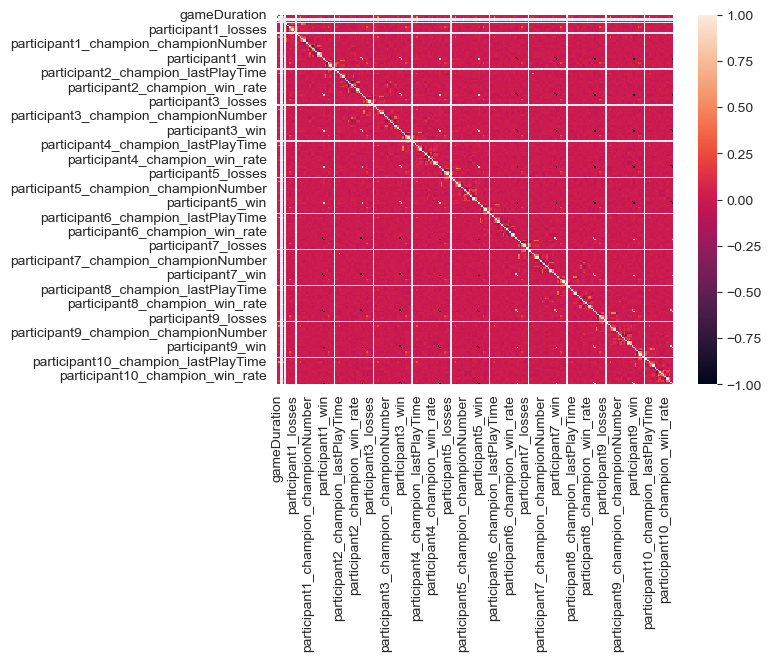

In [79]:
sns.heatmap(df.corr())

In [80]:
df.isna().sum()

gameDuration                        0
gameCreation                        0
gameVersion                         0
mapId                               0
queueId                             0
                                   ..
participant10_champion_pick_rate    0
participant10_champion_ban_rate     0
participant10_champion_matches      0
participant10_teamId                0
participant10_win                   0
Length: 368, dtype: int64

In [81]:
def drop_missing(df: pd.DataFrame):
    len_before = len(df)
    df.dropna(inplace=True, axis=0)
    print(f'dropped {len_before - len(df)} rows')


def replace_missing(df: pd.DataFrame):
    df.fillna(-1, inplace=True)

In [82]:
drop_missing(df)
#replace_missing(df)

dropped 985 rows


the first 5 participants are always in the same team:

In [83]:
df['participant1_win'] == df['participant2_win']

0    True
0    True
0    True
0    True
0    True
     ... 
0    True
0    True
0    True
0    True
0    True
Length: 3453, dtype: bool

In [84]:
df.head()

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_infoDefense,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_tier,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId,participant10_win
0,1402,1696419023286,13.19.534.5972,11,420,19,13,EUW1,293,MASTER,...,2,10,8,B,49.43,0.2,0.2,4544,200,True
0,1871,1696686247380,13.19.534.5972,11,420,19,13,EUW1,58,MASTER,...,1,8,2,D,47.72,6.7,6.7,13856,200,False
0,1420,1696353750966,13.19.533.1909,11,420,19,13,EUW1,121,GRANDMASTER,...,9,5,7,S,50.69,4.0,4.0,20567,200,True
0,1637,1696769278310,13.19.534.5972,11,420,19,13,EUW1,275,GRANDMASTER,...,4,8,5,S+,51.08,5.7,5.7,32255,200,True
0,1596,1696959339412,13.19.534.5972,11,420,19,13,EUW1,603,GRANDMASTER,...,4,5,9,S,52.19,0.6,0.6,11217,200,False


In [85]:
def get_winning_team(df: pd.DataFrame):
    df['label'] = np.where(df['participant1_win'], 0, 1)  # 0 = team1 won, 1 = team2 won 

In [86]:
get_winning_team(df)

In [87]:
def drop_wrong_data(df: pd.DataFrame):
    len_before = len(df)
    df.drop(df[df['mapId'] != 11].index, inplace=True)
    df.drop(df[df['queueId'] != 420].index, inplace=True)
    df.drop(df[df['gameDuration'] < 900].index, inplace=True)
    df.drop(df[df['platformId'] != 'EUW1'].index, inplace=True)
    df.drop(df[df['seasonId'] != 13].index, inplace=True)
    df.drop(df[df['gameVersion'] != df['gameVersion'][0]].index, inplace=True)
    df.drop(df[df['patch'] != df['patch'][0]].index, inplace=True)
    print(f'dropped {len_before - len(df)} rows')

In [88]:
df

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_tier,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId,participant10_win,label
0,1402,1696419023286,13.19.534.5972,11,420,19,13,EUW1,293,MASTER,...,10,8,B,49.43,0.2,0.2,4544,200,True,1
0,1871,1696686247380,13.19.534.5972,11,420,19,13,EUW1,58,MASTER,...,8,2,D,47.72,6.7,6.7,13856,200,False,0
0,1420,1696353750966,13.19.533.1909,11,420,19,13,EUW1,121,GRANDMASTER,...,5,7,S,50.69,4.0,4.0,20567,200,True,1
0,1637,1696769278310,13.19.534.5972,11,420,19,13,EUW1,275,GRANDMASTER,...,8,5,S+,51.08,5.7,5.7,32255,200,True,1
0,1596,1696959339412,13.19.534.5972,11,420,19,13,EUW1,603,GRANDMASTER,...,5,9,S,52.19,0.6,0.6,11217,200,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1622,1696349162755,13.19.533.1909,11,420,19,13,EUW1,293,GRANDMASTER,...,5,9,S,52.19,0.6,0.6,11217,200,True,1
0,1530,1696519987203,13.19.534.5972,11,420,19,13,EUW1,88,CHALLENGER,...,1,7,S+,50.16,11.9,11.9,21645,200,False,0
0,2007,1697065868251,13.20.535.2535,11,420,20,13,EUW1,293,GRANDMASTER,...,8,5,D,48.48,2.6,2.6,24098,200,False,0
0,1921,1696963043367,13.19.534.5972,11,420,19,13,EUW1,548,MASTER,...,9,8,A,50.46,0.3,0.3,5343,200,True,1


In [89]:
drop_wrong_data(df)

dropped 0 rows


In [90]:
def drop_irrelevant(df: pd.DataFrame):
    irrelevant_cols = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                       'platformId']
    for i in range(1, 11):
        irrelevant_cols.append(f'participant{i}_win')
    df.drop(columns=irrelevant_cols, inplace=True)


In [91]:
drop_irrelevant(df)

In [92]:
df.reset_index(inplace=True, drop=True)
df

,participant1_level,participant1_tier,participant1_rank,participant1_leaguePoints,participant1_wins,participant1_losses,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,...,participant10_champion_infoDefense,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_tier,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId,label
0,293,MASTER,1,230,130,122,True,False,False,True,...,2,10,8,B,49.43,0.2,0.2,4544,200,1
1,58,MASTER,1,451,156,126,True,False,False,False,...,1,8,2,D,47.72,6.7,6.7,13856,200,0
2,121,GRANDMASTER,1,644,156,130,False,False,False,False,...,9,5,7,S,50.69,4.0,4.0,20567,200,1
3,275,GRANDMASTER,1,664,117,100,False,False,True,True,...,4,8,5,S+,51.08,5.7,5.7,32255,200,1
4,603,GRANDMASTER,1,616,81,59,False,False,False,False,...,4,5,9,S,52.19,0.6,0.6,11217,200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,293,GRANDMASTER,1,747,381,360,True,False,False,False,...,4,5,9,S,52.19,0.6,0.6,11217,200,1
3449,88,CHALLENGER,1,1123,161,115,True,False,False,False,...,3,1,7,S+,50.16,11.9,11.9,21645,200,0
3450,293,GRANDMASTER,1,747,381,360,True,False,False,False,...,7,8,5,D,48.48,2.6,2.6,24098,200,0
3451,548,MASTER,1,367,78,63,False,False,False,False,...,6,9,8,A,50.46,0.3,0.3,5343,200,1


In [93]:
df['participant1_tier']

0            MASTER
1            MASTER
2       GRANDMASTER
3       GRANDMASTER
4       GRANDMASTER
           ...     
3448    GRANDMASTER
3449     CHALLENGER
3450    GRANDMASTER
3451         MASTER
3452    GRANDMASTER
Name: participant1_tier, Length: 3453, dtype: object

In [94]:
from enum import Enum


class Rank(Enum):
    IRON = 0
    BRONZE = 1
    SILVER = 2
    GOLD = 3
    PLATINUM = 4
    EMERALD = 5
    DIAMOND = 6
    MASTER = 7
    GRANDMASTER = 8
    CHALLENGER = 9


def format_rank(tier: str, rank: str) -> str:
    return f'{tier}.{rank}'


def fix_rank(df: pd.DataFrame):
    for i in range(1, 11):
        df[f'participant{i}_tier'] = df[f'participant{i}_tier'].apply(lambda x: Rank[x].value)
        df.loc[:, f'participant{i}_tier'] = df.apply(
            lambda x: format_rank(x[f'participant{i}_tier'], x[f'participant{i}_rank']), axis=1)
        df[f'participant{i}_tier'] = df[f'participant{i}_tier'].astype(float)
        df.drop(columns=[f'participant{i}_rank'], inplace=True)

In [95]:
fix_rank(df)
df

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_wins,participant1_losses,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,...,participant10_champion_infoDefense,participant10_champion_infoMagic,participant10_champion_infoDifficulty,participant10_champion_tier,participant10_champion_win_rate,participant10_champion_pick_rate,participant10_champion_ban_rate,participant10_champion_matches,participant10_teamId,label
0,293,7.1,230,130,122,True,False,False,True,1697210075000,...,2,10,8,B,49.43,0.2,0.2,4544,200,1
1,58,7.1,451,156,126,True,False,False,False,1696688143000,...,1,8,2,D,47.72,6.7,6.7,13856,200,0
2,121,8.1,644,156,130,False,False,False,False,1696626044000,...,9,5,7,S,50.69,4.0,4.0,20567,200,1
3,275,8.1,664,117,100,False,False,True,True,1697122656000,...,4,8,5,S+,51.08,5.7,5.7,32255,200,1
4,603,8.1,616,81,59,False,False,False,False,1697143514000,...,4,5,9,S,52.19,0.6,0.6,11217,200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,293,8.1,747,381,360,True,False,False,False,1697152707000,...,4,5,9,S,52.19,0.6,0.6,11217,200,1
3449,88,9.1,1123,161,115,True,False,False,False,1696592030000,...,3,1,7,S+,50.16,11.9,11.9,21645,200,0
3450,293,8.1,747,381,360,True,False,False,False,1697067959000,...,7,8,5,D,48.48,2.6,2.6,24098,200,0
3451,548,7.1,367,78,63,False,False,False,False,1697063653000,...,6,9,8,A,50.46,0.3,0.3,5343,200,1


In [96]:
def calc_winrate(df: pd.DataFrame):
    for i in range(1, 11):
        df[f'participant{i}_winrate'] = df[f'participant{i}_wins'] / (
                df[f'participant{i}_wins'] + df[f'participant{i}_losses'])
        df.drop(columns=[f'participant{i}_wins', f'participant{i}_losses'], inplace=True)

In [97]:
calc_winrate(df)
df

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant1_winrate,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate
0,293,7.1,230,True,False,False,True,1697210075000,5,254041,...,0.515873,0.515081,0.521352,0.548638,0.521429,0.512521,0.576577,0.537102,0.500000,0.525253
1,58,7.1,451,True,False,False,False,1696688143000,1,1008,...,0.553191,0.642857,0.585366,0.574074,0.526012,0.513652,0.527415,0.686275,0.590909,0.523207
2,121,8.1,644,False,False,False,False,1696626044000,5,27967,...,0.545455,0.527076,0.594595,0.545763,0.916667,0.535156,0.606299,0.569322,0.590909,0.521739
3,275,8.1,664,False,False,True,True,1697122656000,5,141103,...,0.539171,0.503759,0.531250,0.558621,0.551724,0.537275,0.508117,0.540594,0.596330,0.533101
4,603,8.1,616,False,False,False,False,1697143514000,7,1025108,...,0.578571,0.734375,0.638158,0.842105,0.580508,0.587045,0.541806,0.531568,0.546125,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,293,8.1,747,True,False,False,False,1697152707000,5,166212,...,0.514170,0.444444,0.527778,0.511743,0.520161,0.475000,0.644068,0.546392,0.540984,0.548495
3449,88,9.1,1123,True,False,False,False,1696592030000,4,13788,...,0.583333,0.944444,0.524655,0.599057,0.611354,0.542587,0.536458,0.562162,0.537425,0.556863
3450,293,8.1,747,True,False,False,False,1697067959000,5,50048,...,0.514170,0.524655,0.512500,0.662651,0.561753,0.549550,0.523214,0.534884,0.518212,0.533898
3451,548,7.1,367,False,False,False,False,1697063653000,7,248747,...,0.553191,0.411765,0.611111,0.508306,0.516915,0.654676,0.524297,0.818182,0.368421,0.575221


In [63]:
cols = df.columns.tolist()
index = cols.index('label')
cols = cols[:index] + cols[index + 1:] + [cols[index]]  # label as last column
df = df[cols]

In [64]:
def fix_teamId(df: pd.DataFrame):
    for i in range(1, 11):
        df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1

In [65]:
fix_teamId(df)
df

C:\Users\morit\AppData\Local\Temp\ipykernel_21920\3127685122.py:3: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1
C:\Users\morit\AppData\Local\Temp\ipykernel_21920\3127685122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1
C:\Users\morit\AppData\Local\Temp\ipykernel_21920\3127685122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,293.0,7.1,230.0,1.0,0.0,0.0,1.0,1.697210e+12,5.0,254041.0,...,0.515081,0.521352,0.548638,0.521429,0.512521,0.576577,0.537102,0.500000,0.525253,1.0
1,58.0,7.1,451.0,1.0,0.0,0.0,0.0,1.696688e+12,1.0,1008.0,...,0.642857,0.585366,0.574074,0.526012,0.513652,0.527415,0.686275,0.590909,0.523207,0.0
2,121.0,8.1,644.0,0.0,0.0,0.0,0.0,1.696626e+12,5.0,27967.0,...,0.527076,0.594595,0.545763,0.916667,0.535156,0.606299,0.569322,0.590909,0.521739,1.0
3,275.0,8.1,664.0,0.0,0.0,1.0,1.0,1.697123e+12,5.0,141103.0,...,0.503759,0.531250,0.558621,0.551724,0.537275,0.508117,0.540594,0.596330,0.533101,1.0
4,603.0,8.1,616.0,0.0,0.0,0.0,0.0,1.697144e+12,7.0,1025108.0,...,0.734375,0.638158,0.842105,0.580508,0.587045,0.541806,0.531568,0.546125,0.375000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
def convert_booleans(df: pd.DataFrame):
    df.replace({True: 1, False: 0}, inplace=True)

In [67]:
convert_booleans(df)
df

C:\Users\morit\AppData\Local\Temp\ipykernel_21920\2303047329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({True: 1, False: 0}, inplace=True)


,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,293.0,7.1,230.0,1.0,0.0,0.0,1.0,1.697210e+12,5.0,254041.0,...,0.515081,0.521352,0.548638,0.521429,0.512521,0.576577,0.537102,0.500000,0.525253,1.0
1,58.0,7.1,451.0,1.0,0.0,0.0,0.0,1.696688e+12,1.0,1008.0,...,0.642857,0.585366,0.574074,0.526012,0.513652,0.527415,0.686275,0.590909,0.523207,0.0
2,121.0,8.1,644.0,0.0,0.0,0.0,0.0,1.696626e+12,5.0,27967.0,...,0.527076,0.594595,0.545763,0.916667,0.535156,0.606299,0.569322,0.590909,0.521739,1.0
3,275.0,8.1,664.0,0.0,0.0,1.0,1.0,1.697123e+12,5.0,141103.0,...,0.503759,0.531250,0.558621,0.551724,0.537275,0.508117,0.540594,0.596330,0.533101,1.0
4,603.0,8.1,616.0,0.0,0.0,0.0,0.0,1.697144e+12,7.0,1025108.0,...,0.734375,0.638158,0.842105,0.580508,0.587045,0.541806,0.531568,0.546125,0.375000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
from datetime import datetime


def convert_lastPlayTime(df: pd.DataFrame):
    for i in range(1, 11):
        df.loc[f'participant{i}_champion_lastPlayTime'] = df[f'participant{i}_champion_lastPlayTime'].apply(
            lambda x: int((datetime.now() - datetime.fromtimestamp(x / 1000)).total_seconds()))

In [69]:
df[df.isna().any(axis=1)]

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
participant1_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant2_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant3_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant4_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant5_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant10_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
df.isna().sum()

participant1_level           10
participant1_tier            10
participant1_leaguePoints    10
participant1_veteran         10
participant1_inactive        10
                             ..
participant7_winrate         10
participant8_winrate         10
participant9_winrate         10
participant10_winrate        10
label                        10
Length: 331, dtype: int64

In [71]:
df

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,293.0,7.1,230.0,1.0,0.0,0.0,1.0,1.697210e+12,5.0,254041.0,...,0.515081,0.521352,0.548638,0.521429,0.512521,0.576577,0.537102,0.500000,0.525253,1.0
1,58.0,7.1,451.0,1.0,0.0,0.0,0.0,1.696688e+12,1.0,1008.0,...,0.642857,0.585366,0.574074,0.526012,0.513652,0.527415,0.686275,0.590909,0.523207,0.0
2,121.0,8.1,644.0,0.0,0.0,0.0,0.0,1.696626e+12,5.0,27967.0,...,0.527076,0.594595,0.545763,0.916667,0.535156,0.606299,0.569322,0.590909,0.521739,1.0
3,275.0,8.1,664.0,0.0,0.0,1.0,1.0,1.697123e+12,5.0,141103.0,...,0.503759,0.531250,0.558621,0.551724,0.537275,0.508117,0.540594,0.596330,0.533101,1.0
4,603.0,8.1,616.0,0.0,0.0,0.0,0.0,1.697144e+12,7.0,1025108.0,...,0.734375,0.638158,0.842105,0.580508,0.587045,0.541806,0.531568,0.546125,0.375000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
convert_lastPlayTime(df)
df

ValueError: Invalid value NaN (not a number)

In [ ]:
#for i, col in enumerate(df.columns):
#   plt.figure(i)
#  sns.histplot(df[col], stat='density', kde=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42,
                                                    shuffle=True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.append(X_train, np.expand_dims(y_train, axis=1), axis=1)
X_test = np.append(X_test, np.expand_dims(y_test, axis=1), axis=1)

In [ ]:
X_train

In [ ]:
np.shape(np.expand_dims(y_train, axis=1))

In [ ]:
np.shape(X_train)

In [ ]:
np.save('../data/train_static', X_train)
np.save('../data/test_static', X_test)